In [1]:
import matplotlib.pyplot as plt
from fenics import *
from scipy.signal import correlate2d
from mshr import *
import numpy as np
from dotenv import load_dotenv
import os
from scipy.stats import linregress
from scipy.interpolate import interp1d
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
nueva_ruta = '/media/erick/TOSHIBA EXT/tests'

In [3]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = 1


# Define mesh and space
nodes_in_xaxis=int(os.getenv('nodes_in_xaxis'))
nodes_in_yaxis=int(os.getenv('nodes_in_yaxis'))
space_size=int(os.getenv('space_size'))

os.chdir(nueva_ruta)

In [4]:
def calculate_correlation(field1, field2, field1_name, field2_name, step):
    """
    Calcula la correlación cruzada normalizada entre dos campos 2D usando la fórmula:
    R_{XY}(r) = C_{XY}(r) / (\sigma_X \sigma_Y),
    donde C_{XY}(r) es el promedio de los productos de las áreas solapadas.
    """
    # Calcular media y desviación estándar de cada campo
    mean1, std1 = np.mean(field1), np.std(field1)
    mean2, std2 = np.mean(field2), np.std(field2)
    print(f'Correlación de {field1_name} con {field2_name} al tiempo {step}.')

    # Dimensiones de los campos
    rows, cols = field1.shape
    max_shift = rows - 1

    # Inicializar matriz para almacenar la correlación cruzada
    correlation = np.zeros((2 * rows - 1, 2 * cols - 1))

    # Calcular la correlación cruzada normalizada
    for i in range(-max_shift, max_shift + 1):
        for j in range(-max_shift, max_shift + 1):
            overlap1 = field1[max(0, i):rows + min(0, i), max(0, j):cols + min(0, j)]
            overlap2 = field2[max(0, -i):rows + min(0, -i), max(0, -j):cols + min(0, -j)]
            if overlap1.size > 0:
                C_xy = np.mean((overlap1 - mean1) * (overlap2 - mean2))
                correlation[i + max_shift, j + max_shift] = C_xy / (std1 * std2)
    
    f_save = "correlacion_" + field1_name + field2_name + '_' + "{:.3f}".format(step) + ".txt"
    np.savetxt(f_save, correlation, delimiter="\t")
        
    return print(f'Correlación {field1_name} con {field2_name} al tiempo {step} guardada')

In [5]:
def calculate_correlation_length(file):
    """
    Calcula el valor medio de la longitud de correlación desde una matriz de correlación guardada en un archivo.

    Args:
        file (str): Ruta al archivo que contiene la matriz de correlación.

    Returns:
        float: Valor medio de la longitud de correlación.
    """
    # Cargar la matriz de correlación
    correlation = np.loadtxt(file, delimiter="\t")

    # Calcular el centro de la matriz
    rows, cols = correlation.shape
    center = (rows // 2, cols // 2)

    # Crear matriz de distancias desde el centro
    x = np.arange(-center[1], center[1] + 1)
    y = np.arange(-center[0], center[0] + 1)
    X, Y = np.meshgrid(x, y)
    distances = np.sqrt(X**2 + Y**2)

    # Calcular el valor medio ponderado de las correlaciones respecto a las distancias
    mean_length = np.average(distances, weights=correlation.clip(min=0))

    return mean_length

In [6]:
def plot_radial(matrix, field1_name, field2_name, step, title="Curva del promedio radial"):
    """
    Calcula y grafica el promedio radial desde el centro de una matriz como una curva en 2D,
    marca la longitud de correlación (criterio exponencial) y guarda los resultados en un archivo.

    Args:
        matrix (np.ndarray): Matriz 2D de entrada (por ejemplo, matriz de correlación).
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        space_size (float): Tamaño físico del dominio.
        nodes_in_xaxis (int): Número de nodos en el eje X.
        nodes_in_yaxis (int): Número de nodos en el eje Y.
        title (str): Título del gráfico.
    """
    max_distance = space_size / 2
    dx = space_size / (nodes_in_xaxis - 1)  # Espaciado físico en el eje x
    dy = space_size / (nodes_in_yaxis - 1)  # Espaciado físico en el eje y

    # Calcular el centro de la matriz
    rows, cols = matrix.shape
    center = (rows // 2, cols // 2)
    y, x = np.indices(matrix.shape)
    
    # Escalar las distancias al tamaño físico
    distances = np.sqrt(((x - center[1]) * dx)**2 + ((y - center[0]) * dy)**2)

    # Crear un array para almacenar el promedio radial
    radial_means = []
    unique_distances = np.arange(0, max_distance + dx, dx)

    # Calcular el promedio radial para cada distancia
    for r in unique_distances:
        mask = (distances >= r) & (distances < r + dx)
        if np.any(mask):  # Verificar si hay elementos en esta distancia
            radial_means.append(matrix[mask].mean())
        else:
            radial_means.append(0)

    # Guardar los resultados en un archivo de texto
    output_file = f'radial_average_{field1_name}_{field2_name}_{step:.3f}.txt'
    with open(output_file, "w") as f:
        f.write("Distancia\tPromedio Radial\n")
        for r, mean in zip(unique_distances, radial_means):
            f.write(f"{r:.3f}\t{mean:.6f}\n")

    # Calcular la longitud de correlación (criterio exponencial)
    max_value = radial_means[0]  # C(0), el valor en el centro
    target_value = max_value * np.exp(-1)  # C(0) * e^-1
    mask = np.array(radial_means) <= target_value
    if np.any(mask):
        correlation_length = unique_distances[mask][0]
        print(f"Longitud de correlación (criterio np.exp(-1)) para t = {step:.3f}: {correlation_length:.3f}")
    else:
        correlation_length = None
        print(f"No se encontró longitud de correlación para t = {step:.3f}.")

    # Graficar el promedio radial como curva
    plt.figure(figsize=(8, 6))
    plt.plot(unique_distances, radial_means, marker='o', linestyle='-', color='b', label='Promedio radial')
    plt.axhline(y=target_value, color='r', linestyle='--', label=f'Criterio: C(0) * e^-1 ({target_value:.3f})')
    if correlation_length is not None:
        plt.axvline(x=correlation_length, color='g', linestyle='--', label=f'Longitud de correlación: {correlation_length:.3f}')
    plt.title(title)
    plt.xlabel("Distancia radial desde el centro (unidades físicas)")
    plt.ylabel("Promedio radial")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Devolver los datos para análisis adicional si es necesario
    return unique_distances, radial_means, correlation_length


In [7]:
def plot_correlation(correlation, field1_name, field2_name, step):
    """
    Genera un gráfico 2D de la matriz de correlación cruzada usando el mapa de color "seismic",
    ajustando los ejes a las unidades físicas del dominio.

    Args:
        correlation (np.ndarray): Matriz de correlación cruzada.
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        space_size (float): Tamaño físico del dominio (por defecto 70).
        nodes_in_xaxis (int): Número de nodos en el eje X (por defecto 200).
        nodes_in_yaxis (int): Número de nodos en el eje Y (por defecto 200).
    """
    # Crear los ejes físicos
    x = np.linspace(-space_size / 2, space_size / 2, nodes_in_xaxis)  # Escala física en X
    y = np.linspace(-space_size / 2, space_size / 2, nodes_in_yaxis)  # Escala física en Y

    # Graficar la matriz de correlación con ejes escalados
    plt.figure(figsize=(8, 6))
    plt.imshow(
        correlation,
        extent=[x.min(), x.max(), y.min(), y.max()],  # Ajustar los ejes a las unidades físicas
        origin="lower",
        cmap="seismic"
    )
    plt.colorbar(label="Correlación")
    plt.title(f'Correlación {field1_name} con {field2_name} a t = {step}')
    plt.xlabel("Desplazamiento en X (unidades físicas)")
    plt.ylabel("Desplazamiento en Y (unidades físicas)")
    plt.grid(False)
    plt.show()


In [8]:
def load_field(field1_name, field2_name, step, nb):
    """
    Procesa campos guardados por field_to_numpy_array y calcula correlaciones.

    Args:
        field_name1 (str): Nombre del primer campo (e.g., "c").
        field_name2 (str): Nombre del segundo campo (e.g., "s").
        step (str): Paso de tiempo formateado (e.g., "0.000").
        nb (int): Bloque a procesar.

    Returns:
        dict: Correlación cruzada entre los dos campos.
    """
    file1 = f"matrix_{field1_name}_{step:.3f}_nb_{nb}.txt"
    file2 = f"matrix_{field2_name}_{step:.3f}_nb_{nb}.txt"

    # Cargar los campos
    field1 = np.loadtxt(file1, delimiter="\t")
    field2 = np.loadtxt(file2, delimiter="\t")

    return field1, field2

In [ ]:
def plot_data(file_name, field1_name, field2_name):
    """
    Lee un archivo con dos columnas, grafica los datos en escalas lineal, semilog y log-log.

    Args:
        file_name (str): Nombre del archivo con los datos a graficar.
        field1_name (str): Nombre del primer campo (eje X).
        field2_name (str): Nombre del segundo campo (eje Y).
    """
    # Abrir el archivo como texto si es necesario
    with open(file_name, 'r') as f:
        loaded_array = np.loadtxt(f, delimiter="\t", skiprows=1)

    x = loaded_array[:, 0]  # Primera columna como eje X
    y = loaded_array[:, 1]  # Segunda columna como eje Y

    # Crear las gráficas
    plt.figure(figsize=(12, 8))

    # Gráfico lineal
    plt.subplot(2, 2, 1)
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Lineal')
    plt.title("Escala Lineal")
    plt.xlabel(field1_name)
    plt.ylabel(field2_name)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Gráfico semilogarítmico (eje Y logarítmico)
    plt.subplot(2, 2, 2)
    plt.semilogy(x, y, marker='o', linestyle='-', color='g', label='Semilog (Y)')
    plt.title("Escala Semilogarítmica (Y)")
    plt.xlabel(field1_name)
    plt.ylabel(field2_name)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Gráfico log-log (ambos ejes logarítmicos)
    plt.subplot(2, 2, 3)
    plt.loglog(x, y, marker='o', linestyle='-', color='r', label='Log-Log')
    plt.title("Escala Logarítmica (XY)")
    plt.xlabel(field1_name)
    plt.ylabel(field2_name)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Gráfico semilogarítmico (eje X logarítmico)
    plt.subplot(2, 2, 4)
    plt.semilogx(x, y, marker='o', linestyle='-', color='m', label='Semilog (X)')
    plt.title("Escala Semilogarítmica (X)")
    plt.xlabel(field1_name)
    plt.ylabel(field2_name)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

In [23]:
# Parámetros de entrada
field1_name = "s"  # Campo c (cáncer)
field2_name = "i"  # Campo s (células sanas)

In [ ]:
t = 0.47
while t <= T:
    # Cargar campos
    field1, field2 = load_field(field1_name, field2_name, t, nb)
    calculate_correlation(field1, field2, field1_name, field2_name, t)
    t += dt

Longitud de correlación (criterio np.exp(-1)) para t = 0.000: 0.000


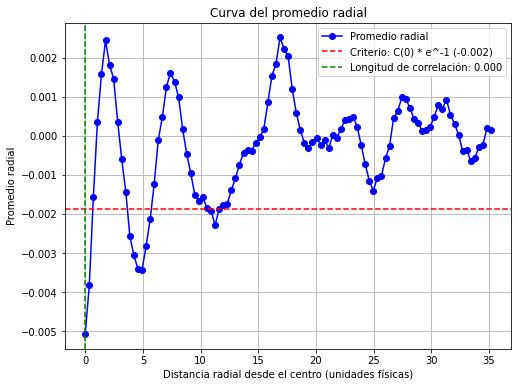

Longitud de correlación (criterio np.exp(-1)) para t = 0.005: 0.000


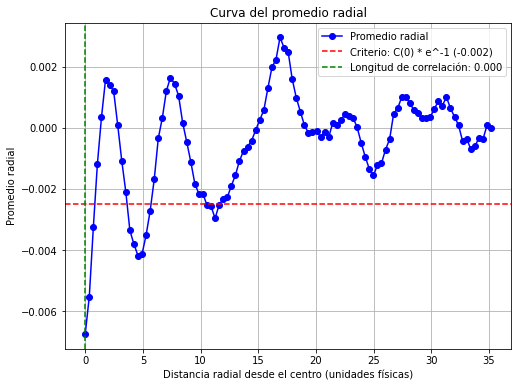

Longitud de correlación (criterio np.exp(-1)) para t = 0.010: 0.000


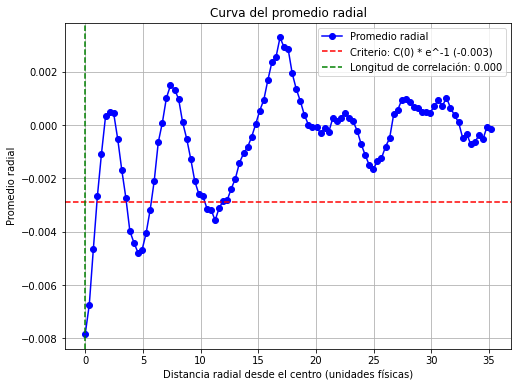

Longitud de correlación (criterio np.exp(-1)) para t = 0.015: 0.000


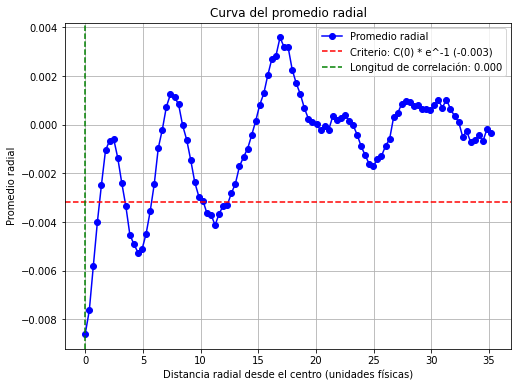

Longitud de correlación (criterio np.exp(-1)) para t = 0.020: 0.000


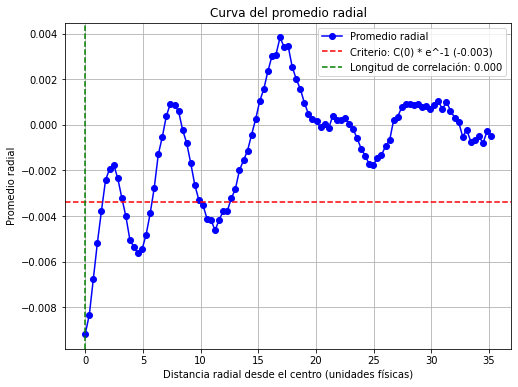

Longitud de correlación (criterio np.exp(-1)) para t = 0.025: 0.000


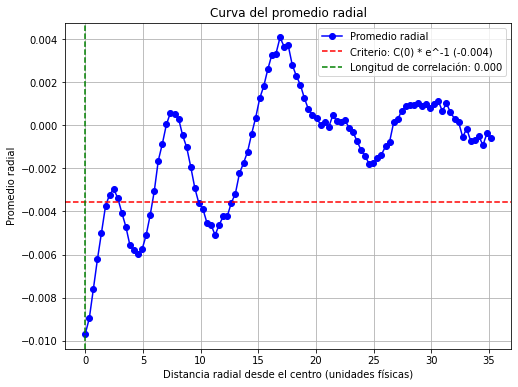

Longitud de correlación (criterio np.exp(-1)) para t = 0.030: 0.000


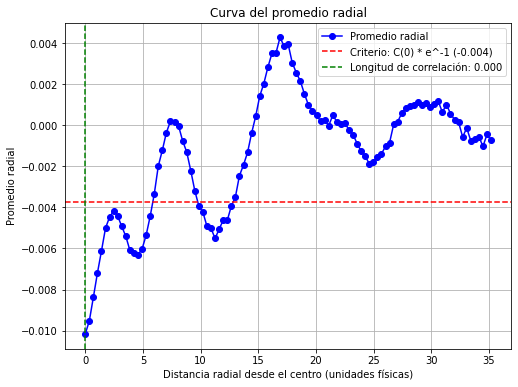

Longitud de correlación (criterio np.exp(-1)) para t = 0.035: 0.000


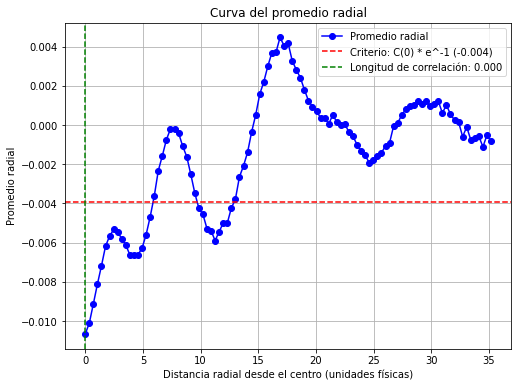

Longitud de correlación (criterio np.exp(-1)) para t = 0.040: 0.000


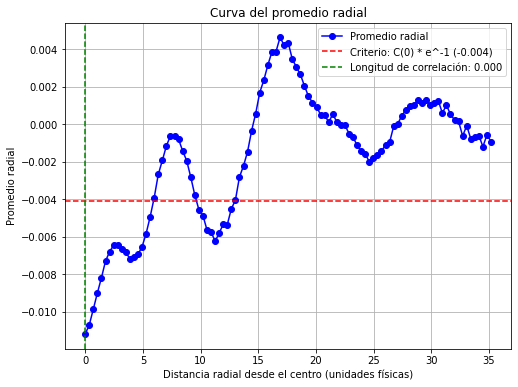

Longitud de correlación (criterio np.exp(-1)) para t = 0.045: 0.000


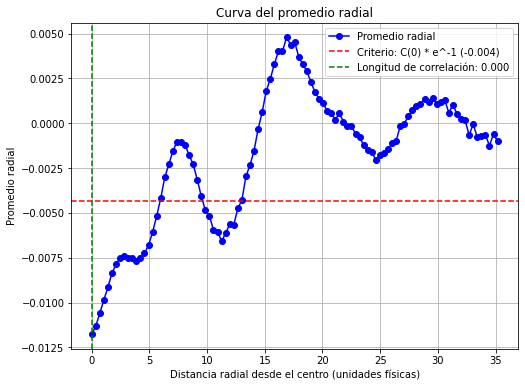

Longitud de correlación (criterio np.exp(-1)) para t = 0.050: 0.000


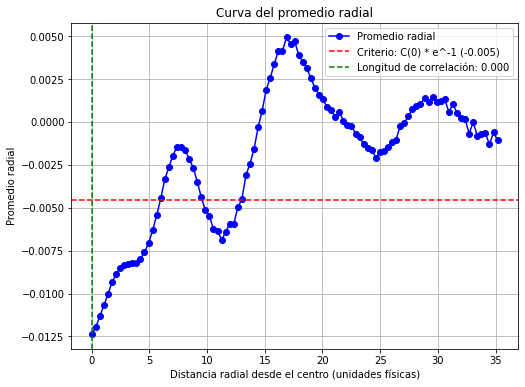

Longitud de correlación (criterio np.exp(-1)) para t = 0.055: 0.000


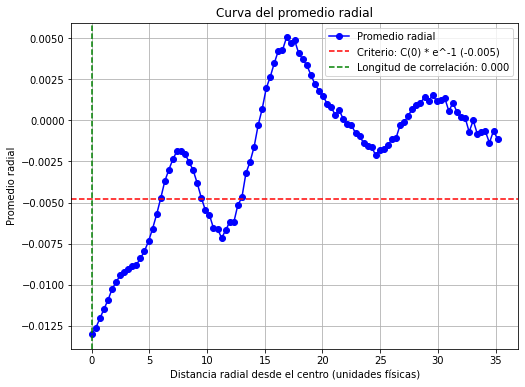

Longitud de correlación (criterio np.exp(-1)) para t = 0.060: 0.000


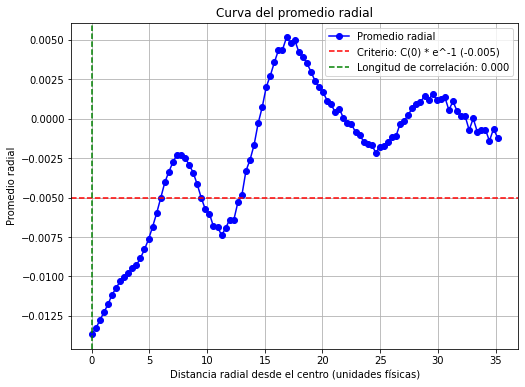

Longitud de correlación (criterio np.exp(-1)) para t = 0.065: 0.000


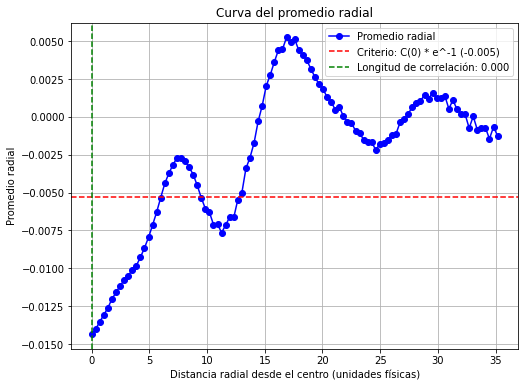

Longitud de correlación (criterio np.exp(-1)) para t = 0.070: 0.000


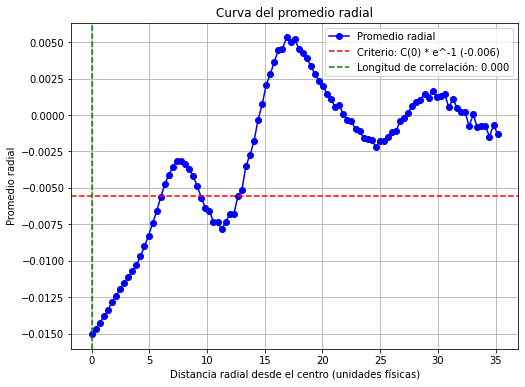

Longitud de correlación (criterio np.exp(-1)) para t = 0.075: 0.000


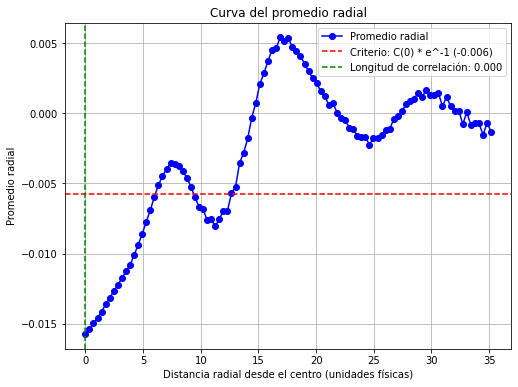

Longitud de correlación (criterio np.exp(-1)) para t = 0.080: 0.000


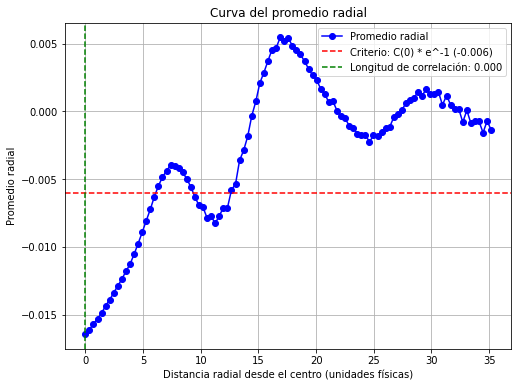

Longitud de correlación (criterio np.exp(-1)) para t = 0.085: 0.000


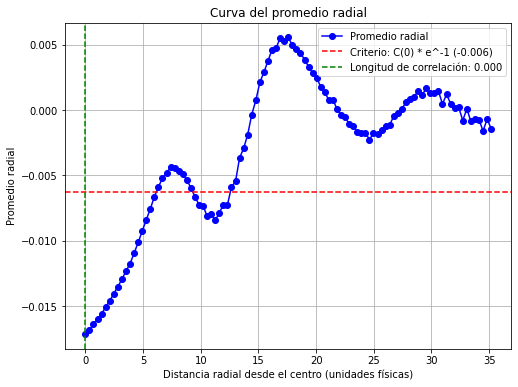

Longitud de correlación (criterio np.exp(-1)) para t = 0.090: 0.000


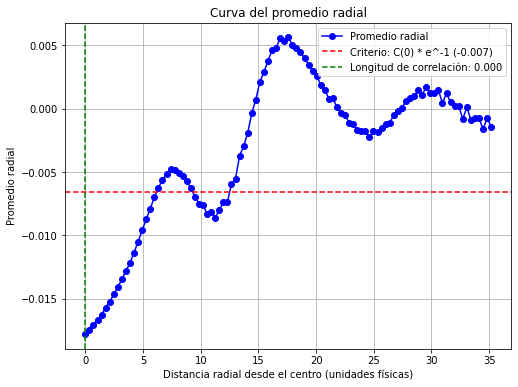

Longitud de correlación (criterio np.exp(-1)) para t = 0.095: 0.000


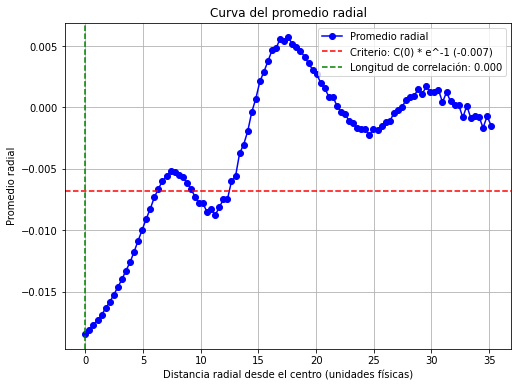

Longitud de correlación (criterio np.exp(-1)) para t = 0.100: 0.000


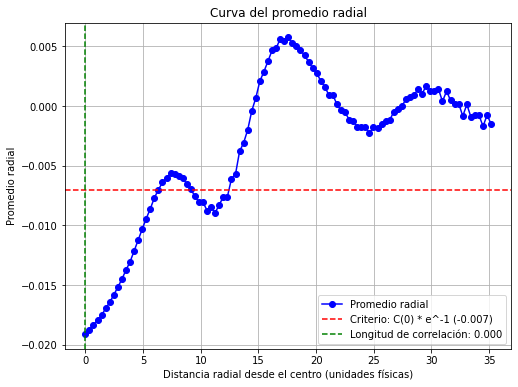

Longitud de correlación (criterio np.exp(-1)) para t = 0.105: 0.000


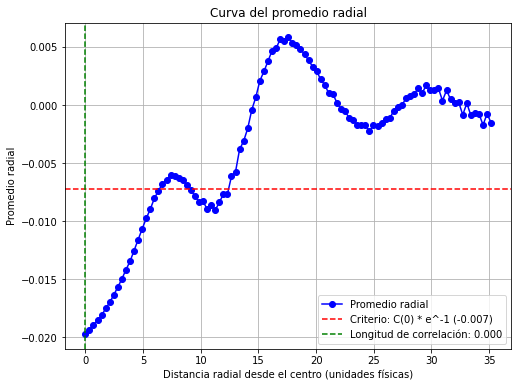

Longitud de correlación (criterio np.exp(-1)) para t = 0.110: 0.000


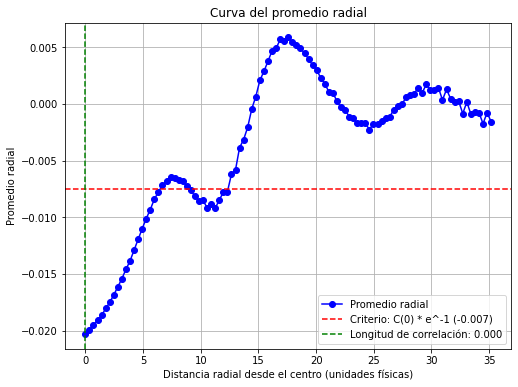

Longitud de correlación (criterio np.exp(-1)) para t = 0.115: 0.000


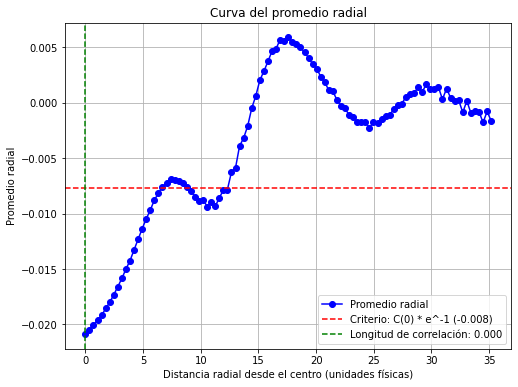

Longitud de correlación (criterio np.exp(-1)) para t = 0.120: 0.000


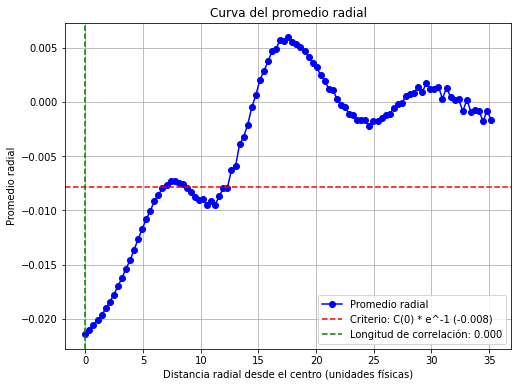

Longitud de correlación (criterio np.exp(-1)) para t = 0.125: 0.000


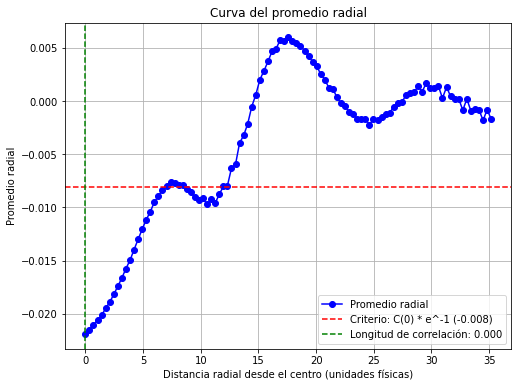

Longitud de correlación (criterio np.exp(-1)) para t = 0.130: 0.000


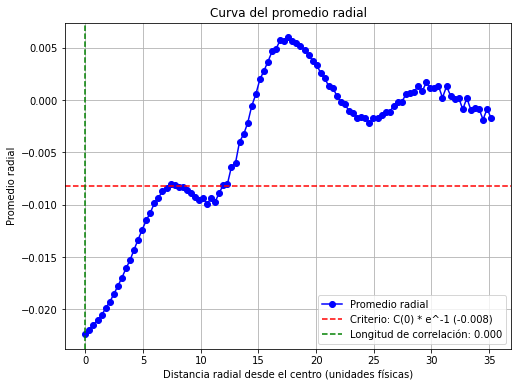

Longitud de correlación (criterio np.exp(-1)) para t = 0.135: 0.000


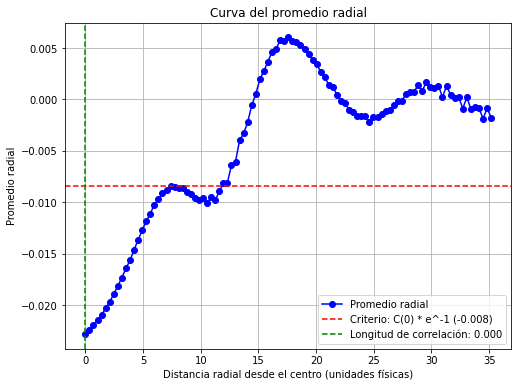

Longitud de correlación (criterio np.exp(-1)) para t = 0.140: 0.000


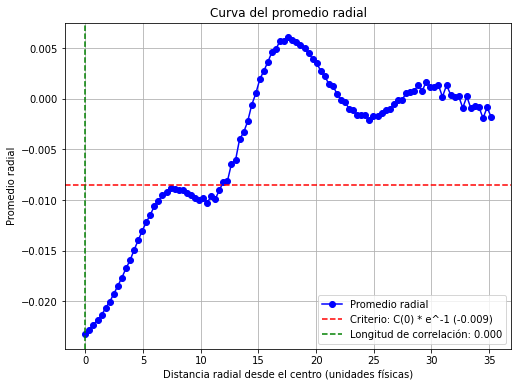

Longitud de correlación (criterio np.exp(-1)) para t = 0.145: 0.000


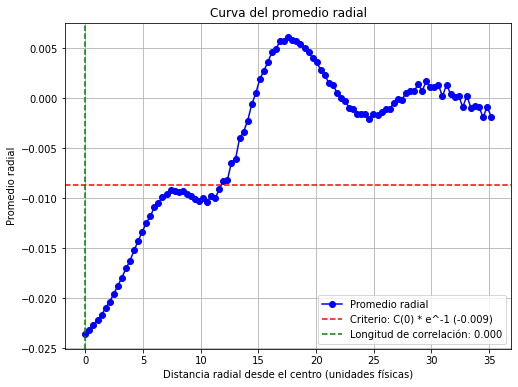

Longitud de correlación (criterio np.exp(-1)) para t = 0.150: 0.000


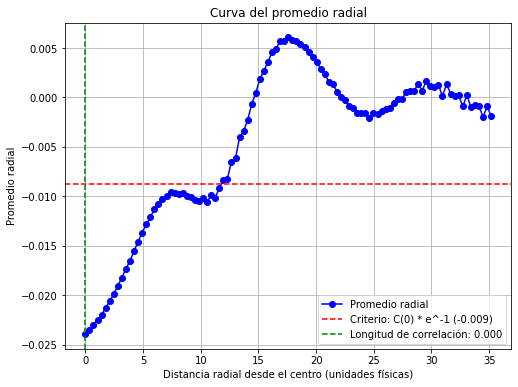

Longitud de correlación (criterio np.exp(-1)) para t = 0.155: 0.000


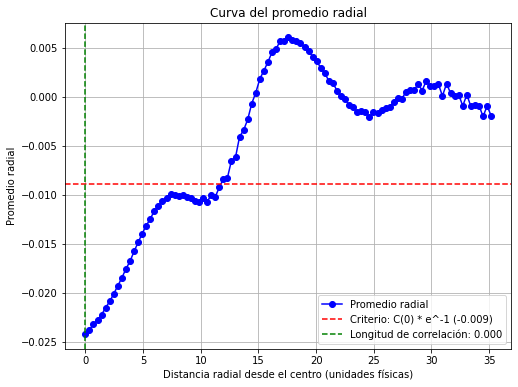

Longitud de correlación (criterio np.exp(-1)) para t = 0.160: 0.000


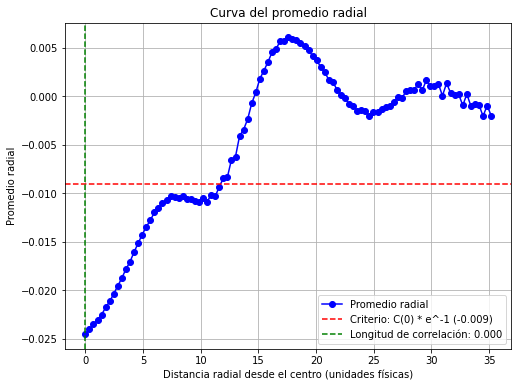

Longitud de correlación (criterio np.exp(-1)) para t = 0.165: 0.000


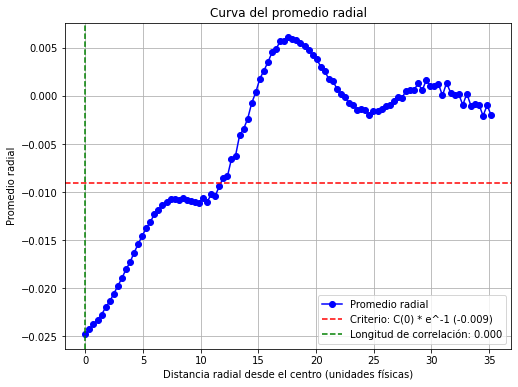

Longitud de correlación (criterio np.exp(-1)) para t = 0.170: 0.000


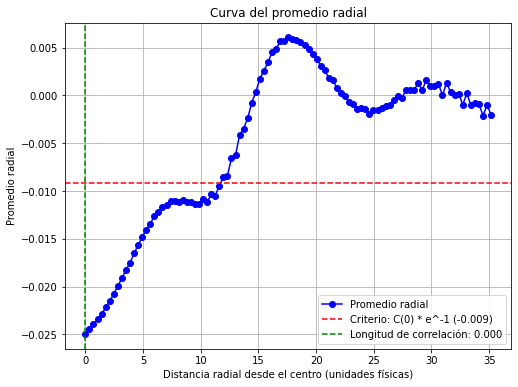

Longitud de correlación (criterio np.exp(-1)) para t = 0.175: 0.000


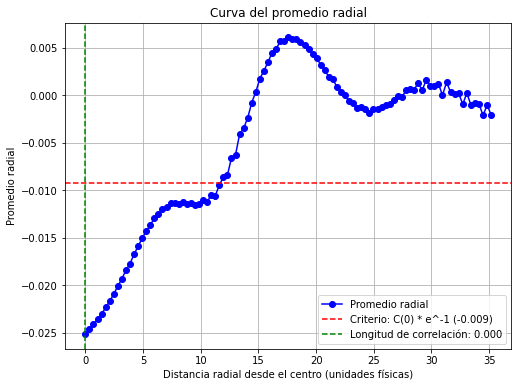

Longitud de correlación (criterio np.exp(-1)) para t = 0.180: 0.000


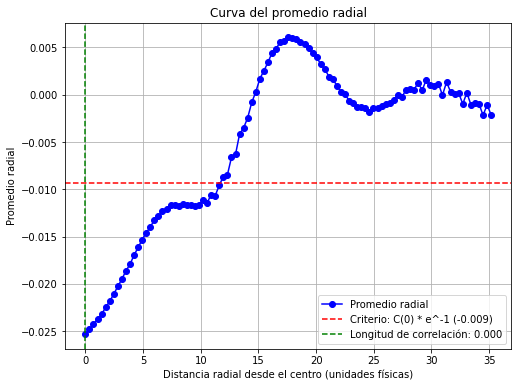

Longitud de correlación (criterio np.exp(-1)) para t = 0.185: 0.000


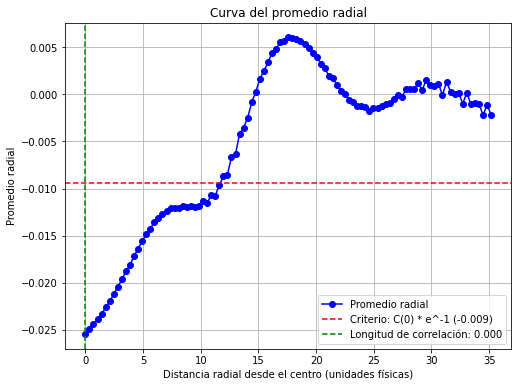

Longitud de correlación (criterio np.exp(-1)) para t = 0.190: 0.000


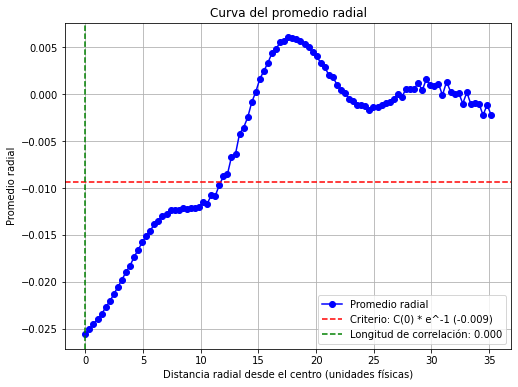

Longitud de correlación (criterio np.exp(-1)) para t = 0.195: 0.000


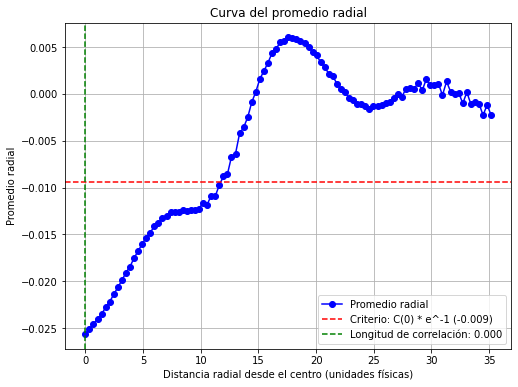

Longitud de correlación (criterio np.exp(-1)) para t = 0.200: 0.000


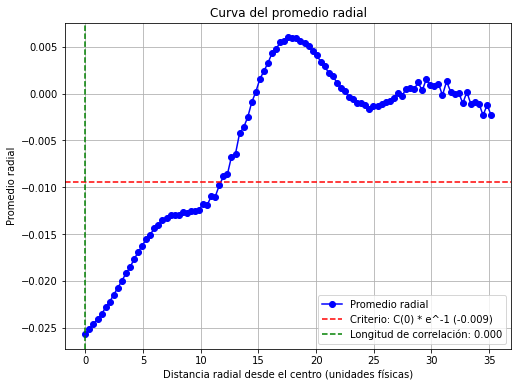

Longitud de correlación (criterio np.exp(-1)) para t = 0.205: 0.000


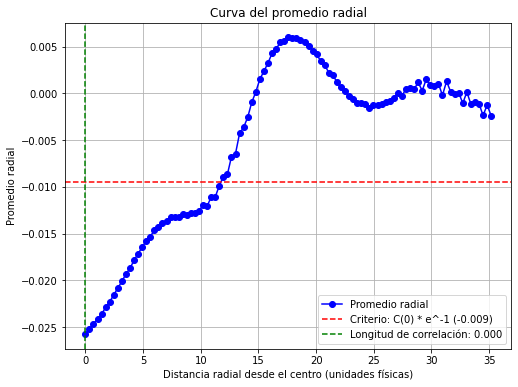

Longitud de correlación (criterio np.exp(-1)) para t = 0.210: 0.000


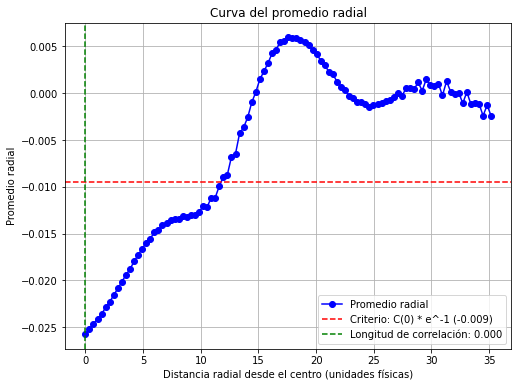

Longitud de correlación (criterio np.exp(-1)) para t = 0.215: 0.000


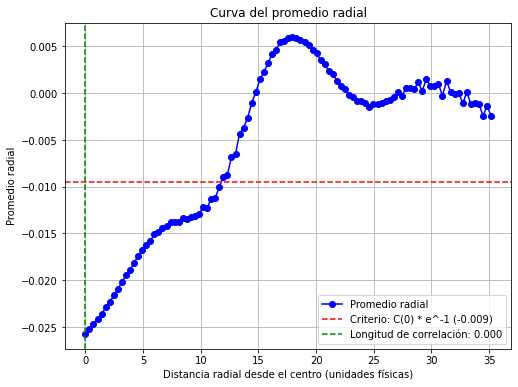

Longitud de correlación (criterio np.exp(-1)) para t = 0.220: 0.000


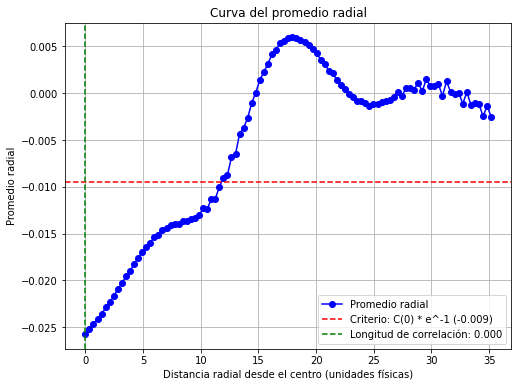

Longitud de correlación (criterio np.exp(-1)) para t = 0.225: 0.000


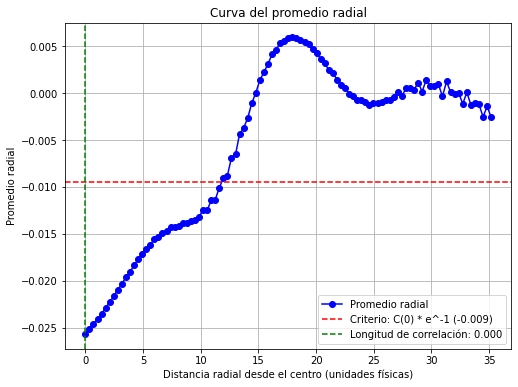

Longitud de correlación (criterio np.exp(-1)) para t = 0.230: 0.000


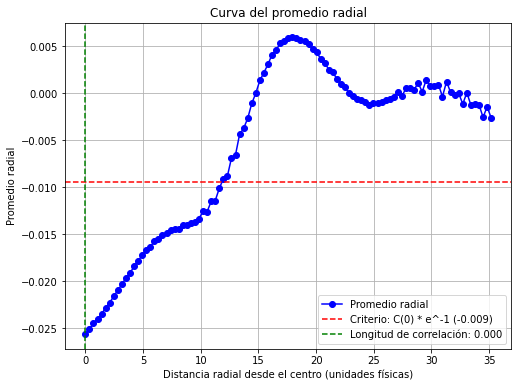

Longitud de correlación (criterio np.exp(-1)) para t = 0.235: 0.000


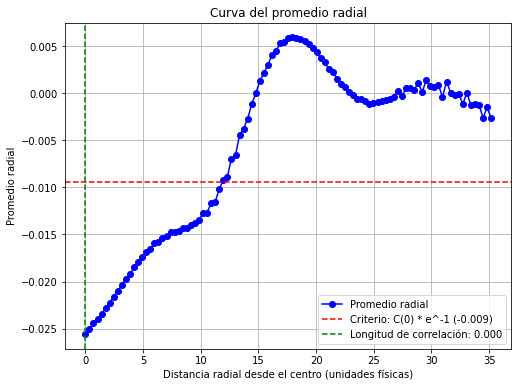

Longitud de correlación (criterio np.exp(-1)) para t = 0.240: 0.000


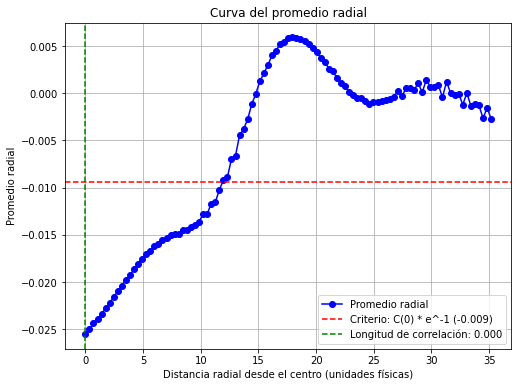

Longitud de correlación (criterio np.exp(-1)) para t = 0.245: 0.000


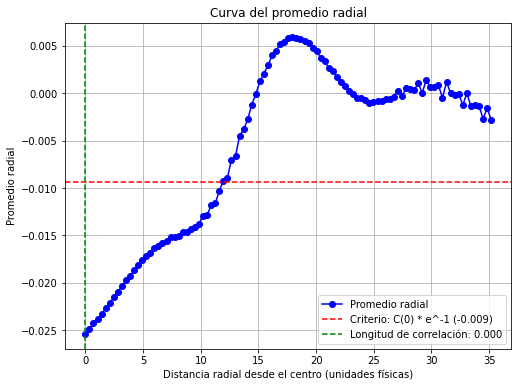

Longitud de correlación (criterio np.exp(-1)) para t = 0.250: 0.000


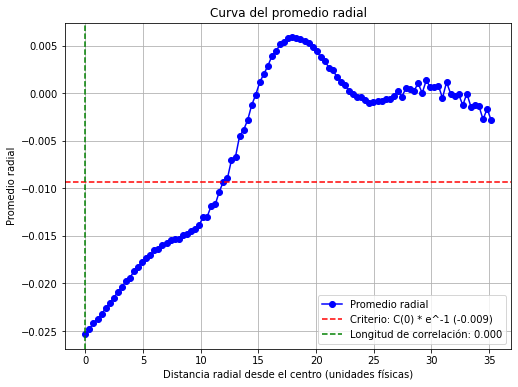

Longitud de correlación (criterio np.exp(-1)) para t = 0.255: 0.000


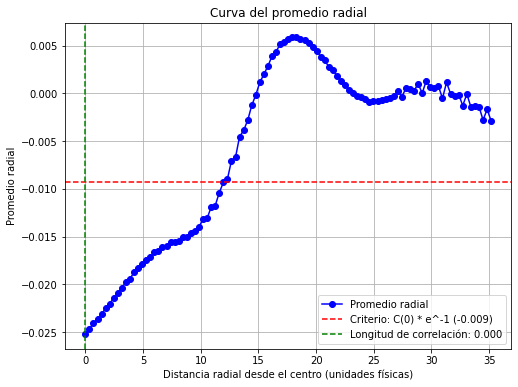

Longitud de correlación (criterio np.exp(-1)) para t = 0.260: 0.000


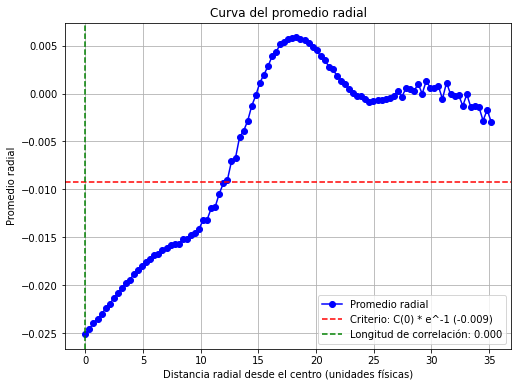

Longitud de correlación (criterio np.exp(-1)) para t = 0.265: 0.000


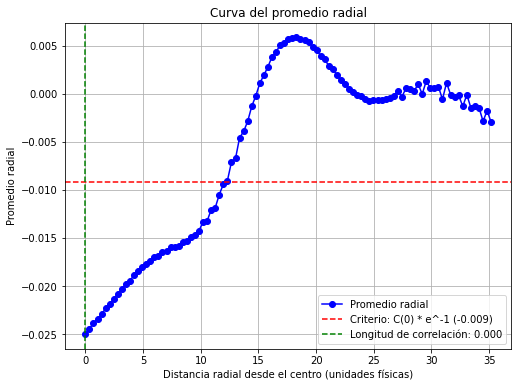

Longitud de correlación (criterio np.exp(-1)) para t = 0.270: 0.000


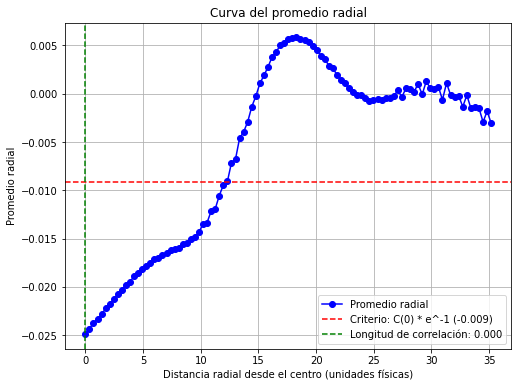

Longitud de correlación (criterio np.exp(-1)) para t = 0.275: 0.000


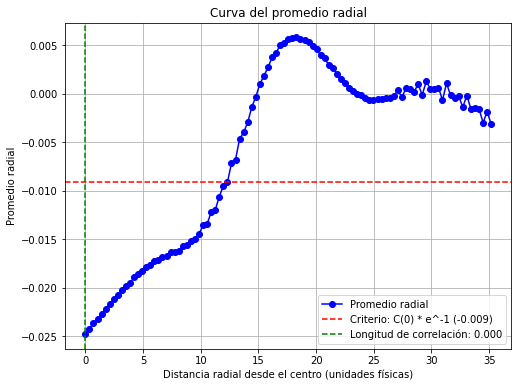

Longitud de correlación (criterio np.exp(-1)) para t = 0.280: 0.000


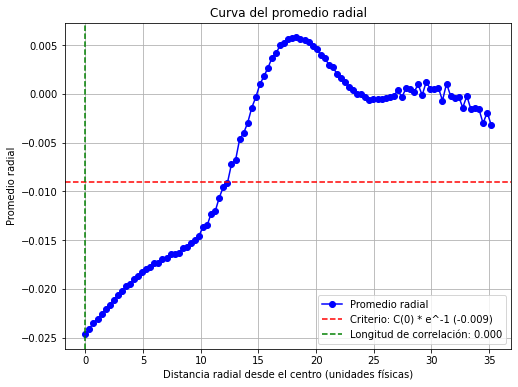

Longitud de correlación (criterio np.exp(-1)) para t = 0.285: 0.000


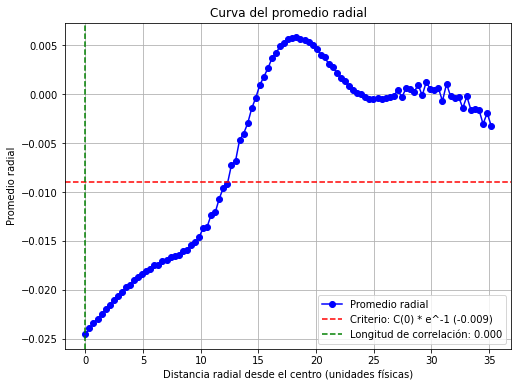

Longitud de correlación (criterio np.exp(-1)) para t = 0.290: 0.000


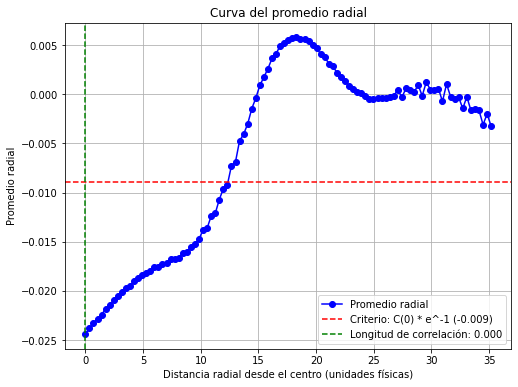

Longitud de correlación (criterio np.exp(-1)) para t = 0.295: 0.000


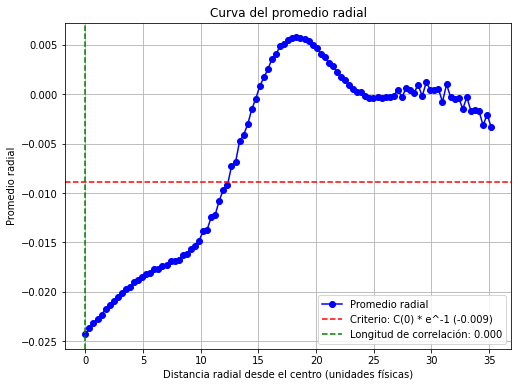

Longitud de correlación (criterio np.exp(-1)) para t = 0.300: 0.000


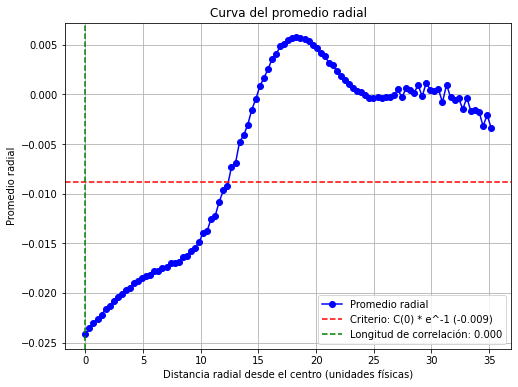

Longitud de correlación (criterio np.exp(-1)) para t = 0.305: 0.000


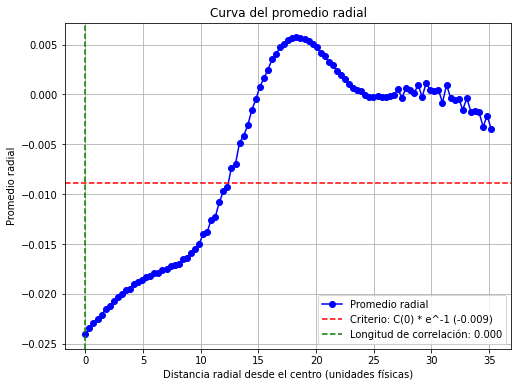

In [ ]:
t = 0
length_corr = []
while t <= T:
    file1 = f'correlacion_{field1_name}{field2_name}_{t:.3f}.txt'
    corr = np.loadtxt(file1, delimiter="\t")
    unique_distances, radial_means, correlation_length = plot_radial(corr, field1_name, field2_name, t, title="Curva del promedio radial")
    # plot_correlation(corr, field1_name, field2_name, t)
    length_corr.append([t, correlation_length])
    t += dt

In [22]:
length_corr = np.array(length_corr)
np.savetxt(
    f'corr_length_time_{field1_name}_{field2_name}.txt',   # Nombre del archivo
    length_corr,                # Array a guardar
    fmt="%.2f",                # Formato de los valores (dos decimales)
    delimiter="\t",            # Separador (tabulación en este caso)
    header="Col1\tCol2"        # Encabezados de las columnas
)

In [ ]:
loaded_array = f'corr_length_time_{field1_name}_{field2_name}.txt'

In [ ]:
plot_data(loaded_array, field1_name, field2_name)